In [24]:
import scanpy as sc
import pandas as pd
import infercnvpy as cnv

In [25]:
import sys
sys.path.append("/home/augusta/SSS_mount/insituCNV/InSituCNV/modules")
sys.path.append("/home/augusta/SSS_mount/insituCNV/InSituCNV")
import infercnv_pipeline as ip
import insitucnv as icv
import numpy as np

In [26]:
adata = sc.read(f"/home/augusta/insituCNV/snPATHOseq_221.h5ad")

In [27]:
read_depth = adata.layers['raw'].sum(axis=1)

average_read_depth = read_depth.mean()
average_read_depth

3226.391663048198

In [ ]:
# df =  pd.DataFrame(adata.var_names, columns=["gene_names"])
# df.to_csv('snPATHOseq_221_genes.csv')

In [ ]:
import pandas as pd

# Step 1: Read the CSV files into Pandas DataFrames
df1 = pd.read_csv("/home/augusta/SSS_mount/insituCNV/InSituCNV/Figure1/CosMx_CRC/3_inferCNV/CosMx_221_genes.csv")
df2 = pd.read_csv("/home/augusta/SSS_mount/insituCNV/InSituCNV/Figure1/CosMx_CRC/3_inferCNV/snPATHO-seq/snPATHOseq_221_genes.csv") 

# Step 2: Extract gene names as sets (adjust column names if needed)
genes_1 = set(df1['gene_names'])
genes_2 = set(df2['gene_names'])

# Step 3: Find common genes using set intersection
common_genes = genes_1.intersection(genes_2)

# Step 4: Print the number of common genes
print(f"Number of common genes: {len(common_genes)}")

In [ ]:
groupby='epi_cnv_leiden_res0.1'
save_heatmap = f"_summary_snPATHOseq_{sid}_groupby-{groupby}.pdf"
# save_heatmap = None
cnv.pl.chromosome_heatmap_summary(adata, groupby=groupby, dendrogram=True, save=save_heatmap, vmin=-.4, vmax=0.4)

In [ ]:
# Step 5: Optionally, save the common genes to a new CSV file
common_genes_df = pd.DataFrame(list(common_genes), columns=["common_genes"])
common_genes_df.to_csv("221_common_genes.csv", index=False)

In [15]:
common_genes_df = pd.read_csv("221_common_genes.csv")
common_genes_df.head()

,common_genes
0,PHYHIPL
1,MAPKAPK2
2,AGFG2
3,ELMO2
4,ACOT7


In [28]:
adata = adata[:, adata.var_names.isin(common_genes_df['common_genes'])].copy()

In [29]:
adata

AnnData object with n_obs × n_vars = 2303 × 14044
    obs: 'pid', 'run', 'sid', 'sum', 'detected', 'subsets_mt_sum', 'subsets_mt_detected', 'subsets_mt_percent', 'total', 'sizeFactor', 'kid', 'decontX_contamination', 'decontX_clusters', 'sum.1', 'detected.1', 'subsets_mt_sum.1', 'subsets_mt_detected.1', 'subsets_mt_percent.1', 'total.1', 'scDblFinder.sample', 'scDblFinder.cluster', 'scDblFinder.class', 'scDblFinder.score', 'scDblFinder.weighted', 'scDblFinder.difficulty', 'scDblFinder.cxds_score', 'scDblFinder.mostLikelyOrigin', 'scDblFinder.originAmbiguous', 'lv1', 'barcode'
    var: 'ensembl_id', 'gene_symbol', 'subsets_mt', 'gene_id', 'symbol', 'ensg', 'chromosome', 'start', 'end'
    uns: 'X_name', 'lv1_colors', 'scDblFinder.stats', 'scDblFinder.threshold', 'sid_colors'
    obsm: 'PCA', 'UMAP', 'X_pca', 'X_umap'
    layers: 'X', 'logcounts', 'raw'

  0%|          | 0/1 [00:00<?, ?it/s]

... storing 'epi_cnv_leiden_res0.1' as categorical


categories: 0, 1, 2, etc.
var_group_labels: chr1, chr2, chr3, etc.


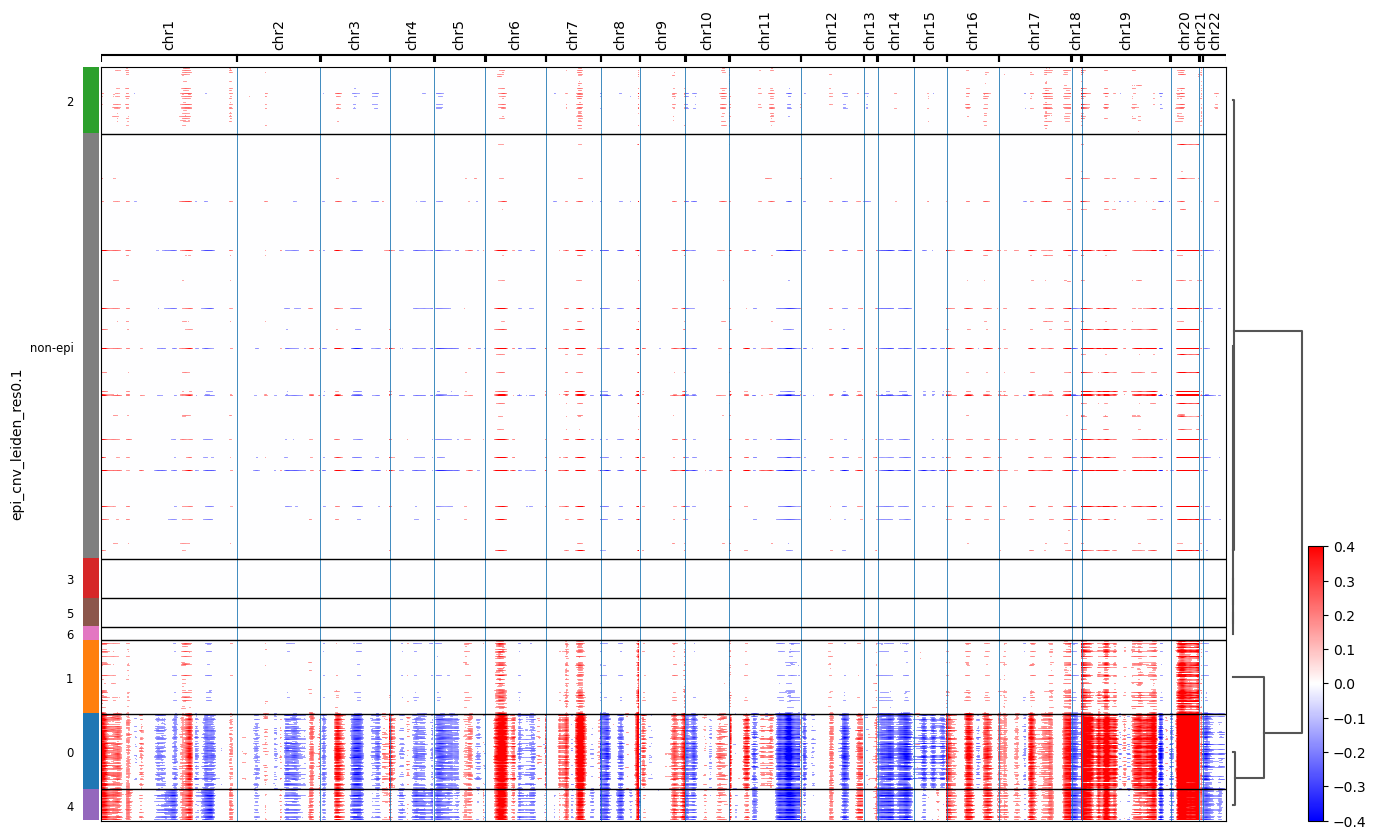

... storing 'epi_cnv_leiden_res0.1' as categorical
... storing 'epi_cnv_leiden_res0.3' as categorical


categories: 0, 1, 2, etc.
var_group_labels: chr1, chr2, chr3, etc.


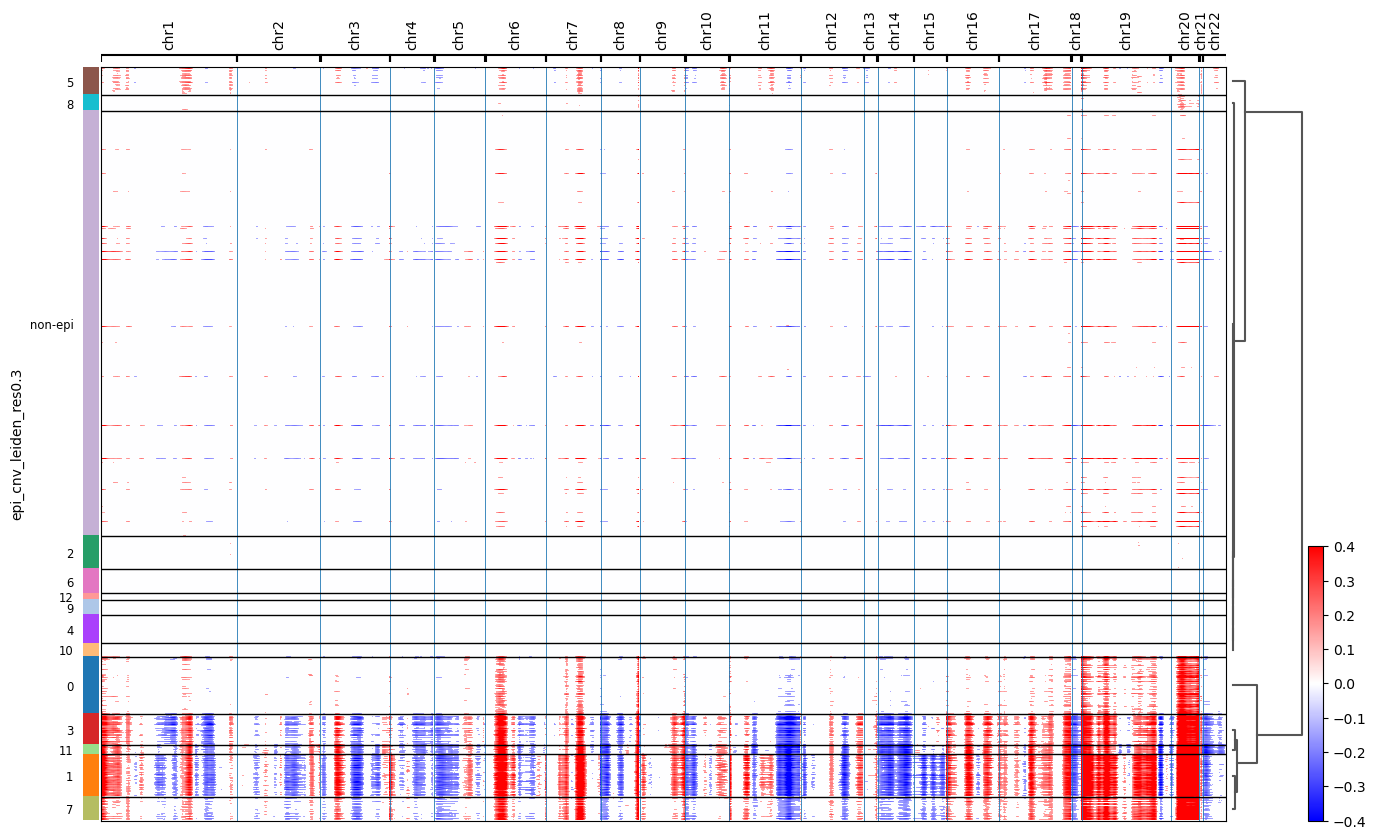

... storing 'epi_cnv_leiden_res0.1' as categorical
... storing 'epi_cnv_leiden_res0.3' as categorical
... storing 'epi_cnv_leiden_res0.5' as categorical


categories: 0, 1, 2, etc.
var_group_labels: chr1, chr2, chr3, etc.


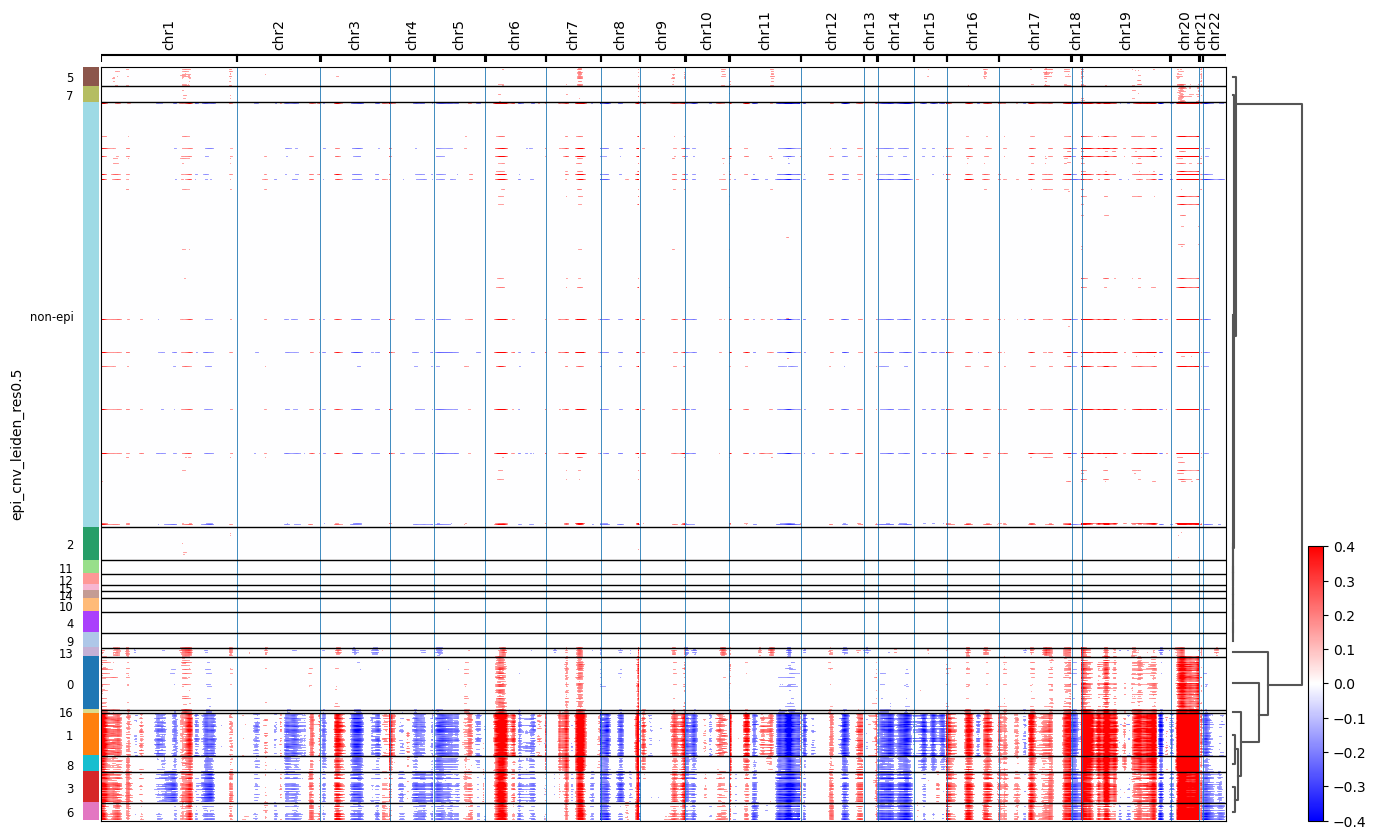

... storing 'epi_cnv_leiden_res0.1' as categorical
... storing 'epi_cnv_leiden_res0.3' as categorical
... storing 'epi_cnv_leiden_res0.5' as categorical


In [32]:
# Smooth the data
adata.X = adata.layers['logcounts'].copy()
sc.pp.pca(adata)
sc.pp.neighbors(adata)
icv.tl.smooth_data_for_cnv(adata, n_neighbors=20)
adata.X = adata.layers['M'].copy()    
cnv.tl.infercnv(adata, 
                reference_key = 'lv1',
                reference_cat = ['fib1', 'fib2', 'mast', 'mye1', 'mye2','BC', 'EC', 'PC_IgA', 'PC_IgG', 'PC_IgM', 'SMC', 'TC'],
                window_size=100)    
adata_epi = adata[adata.obs.lv1.isin(['epi1', 'epi2', 'epi3', 'epi4','Uknown'])].copy()
cnv.tl.pca(adata_epi)    
cnv.pp.neighbors(adata_epi)

resolutions=[0.1, 0.3, 0.5]

for res in resolutions:    
    key_added=f'epi_cnv_leiden_res{res}'
    cnv.tl.leiden(adata_epi, resolution = res, key_added=key_added)
    adata.obs[key_added] = np.nan
    adata.obs.loc[adata_epi.obs_names, key_added] = adata_epi.obs[key_added]

    adata.obs[key_added].fillna("non-epi", inplace=True)
    # save_heatmap = f"_snPATHOseq_{sid}_common_smooth_groupby-{key_added}.png"
    save_heatmap = None
    cnv.pl.chromosome_heatmap(adata, groupby=key_added, dendrogram=True, save=save_heatmap, vmin=-.4, vmax=0.4) #, vmin=-.4, vmax=.4) 


adata.write(f"/home/augusta/insituCNV/snPATHOseq_{sid}_common_genes_smooth_CNVinf.h5ad")

categories: 0, 1, 2, etc.
var_group_labels: chr1, chr2, chr3, etc.


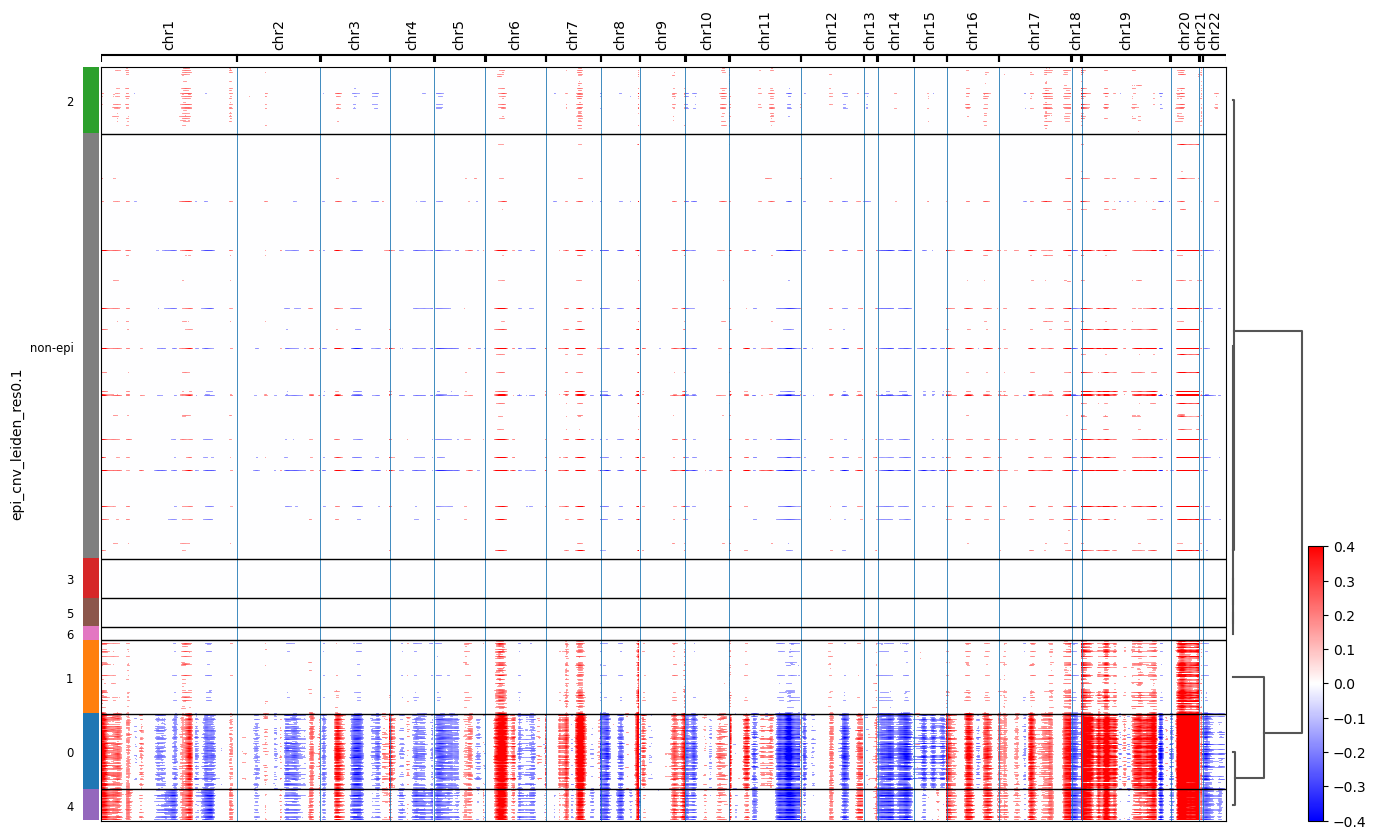

In [35]:
groupby='epi_cnv_leiden_res0.1'
save_heatmap = f"_snPATHOseq_{sid}_common_groupby-{groupby}.pdf"
# save_heatmap = None
cnv.pl.chromosome_heatmap(adata, groupby=groupby, dendrogram=True, save=save_heatmap, vmin=-.4, vmax=0.4)